**CAMB Python example notebook**

Run it online yourself in [Binder](https://mybinder.org/v2/gh/cmbant/camb/master?filepath=pycamb%2Fdocs%2FCAMBdemo.ipynb).

In [1]:
%matplotlib inline
import sys, platform, os
from matplotlib import pyplot as plt
import numpy as np
print('Using CAMB installed at %s'%(os.path.realpath(os.path.join(os.getcwd(),'..'))))
#uncomment this if you are running remotely and want to keep in synch with repo changes
#if platform.system()!='Windows':
#    !cd $HOME/git/camb; git pull github master; git log -1
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
import camb
from camb import model, initialpower
print('CAMB version: %s '%camb.__version__)

Using CAMB installed at c:\work\dist\git\camb\pycamb
CAMB version: 0.3.0 


In [2]:
#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
pars.set_for_lmax(2500, lens_potential_accuracy=0);

In [3]:
#calculate results for these parameters
results = camb.get_results(pars)

In [4]:
#get dictionary of CAMB power spectra
powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')
for name in powers: print(name)

total
unlensed_scalar
unlensed_total
lensed_scalar
tensor
lens_potential


(2551, 4)


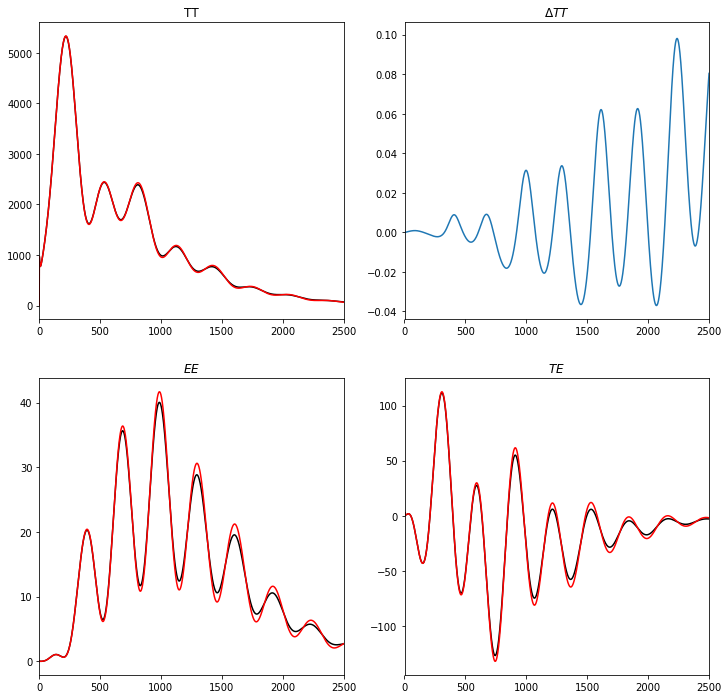

In [5]:
#plot the total lensed CMB power spectra versus unlensed, and fractional difference
totCL=powers['total']
unlensedCL=powers['unlensed_scalar']
print(totCL.shape)
#Python CL arrays are all zero based (starting at L=0), Note L=0,1 entries will be zero by default.
#The different CL are always in the order TT, EE, BB, TE (with BB=0 for unlensed scalar results).
ls = np.arange(totCL.shape[0])
fig, ax = plt.subplots(2,2, figsize = (12,12))
ax[0,0].plot(ls,totCL[:,0], color='k')
ax[0,0].plot(ls,unlensedCL[:,0], color='r')
ax[0,0].set_title('TT')
ax[0,1].plot(ls[2:], 1-unlensedCL[2:,0]/totCL[2:,0]);
ax[0,1].set_title(r'$\Delta TT$')
ax[1,0].plot(ls,totCL[:,1], color='k')
ax[1,0].plot(ls,unlensedCL[:,1], color='r')
ax[1,0].set_title(r'$EE$')
ax[1,1].plot(ls,totCL[:,3], color='k')
ax[1,1].plot(ls,unlensedCL[:,3], color='r')
ax[1,1].set_title(r'$TE$');
for ax in ax.reshape(-1): ax.set_xlim([2,2500]);


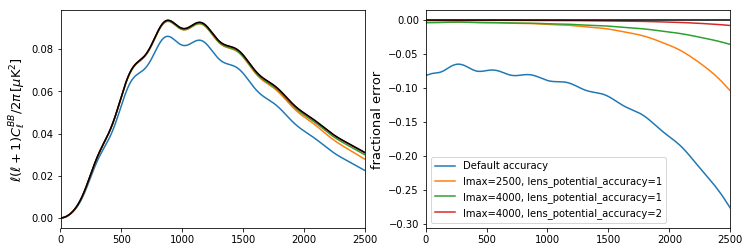

In [6]:
# The lensing B modes are non-linear, so need to be calculated carefully if you want them accurate (even at low ell)
# Need both high lmax, non-linear lensing and high k 
# lens_potential_accuracy=1 turns on the latter, and can be increased to check precision

pars.set_for_lmax(2500, lens_potential_accuracy=1)
results = camb.get_results(pars)
lmax2500CL = results.get_lensed_scalar_cls(CMB_unit='muK')
                  
pars.set_for_lmax(4000, lens_potential_accuracy=1)
results = camb.get_results(pars)
lmax4000CL = results.get_lensed_scalar_cls(CMB_unit='muK')

pars.set_for_lmax(4000, lens_potential_accuracy=2)
results = camb.get_results(pars)
accCL = results.get_lensed_scalar_cls(CMB_unit='muK')

pars.set_for_lmax(6000, lens_potential_accuracy=4)
results = camb.get_results(pars)
refCL = results.get_lensed_scalar_cls(CMB_unit='muK')


fig, ax = plt.subplots(1,2, figsize = (12,4))
ax[0].plot(ls,totCL[:len(ls),2], color='C0')
ax[0].plot(ls,lmax2500CL[:len(ls),2], color='C1')
ax[0].plot(ls,lmax4000CL[:len(ls),2], color='C2')
ax[0].plot(ls,accCL[:len(ls),2], color='C3')
ax[0].plot(ls,refCL[:len(ls),2], color='k')

ax[0].set_xlim([2,2500])
ax[0].set_ylabel(r'$\ell(\ell+1)C_\ell^{BB}/2\pi\,[\mu {\rm K}^2]$', fontsize=13)

ax[1].plot(ls[2:],totCL[2:len(ls),2]/refCL[2:len(ls),2]-1, color='C0')
ax[1].plot(ls[2:],lmax2500CL[2:len(ls),2]/refCL[2:len(ls),2]-1, color='C1')
ax[1].plot(ls[2:],lmax4000CL[2:len(ls),2]/refCL[2:len(ls),2]-1, color='C2')
ax[1].plot(ls[2:],accCL[2:len(ls),2]/refCL[2:len(ls),2]-1, color='C3')

ax[1].axhline(0,color='k')
ax[1].set_xlim([2,2500])
ax[1].set_ylabel('fractional error', fontsize=13);
ax[1].legend(['Default accuracy','lmax=2500, lens_potential_accuracy=1',
           'lmax=4000, lens_potential_accuracy=1','lmax=4000, lens_potential_accuracy=2']);


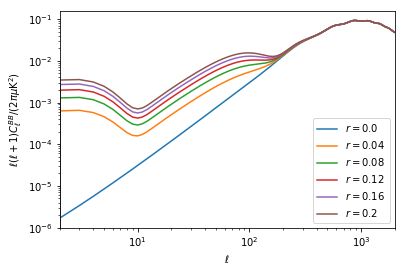

In [7]:
#You can calculate spectra for different primordial power spectra without recalculating everything
#for example, let's plot the BB spectra as a function of r
pars.set_for_lmax(4000, lens_potential_accuracy=1)
pars.WantTensors = True
results = camb.get_transfer_functions(pars)
lmax=2000
rs = np.linspace(0,0.2,6)
for r in rs:
    inflation_params = initialpower.InitialPowerLaw()
    inflation_params.set_params(ns=0.96, r=r)
    results.power_spectra_from_transfer(inflation_params) #warning OK here, not changing scalars
    cl = results.get_total_cls(lmax, CMB_unit='muK')
    plt.loglog(np.arange(lmax+1),cl[:,2])
plt.xlim([2,lmax])
plt.legend(["$r = %s$"%r for r in  rs], loc='lower right');
plt.ylabel(r'$\ell(\ell+1)C_\ell^{BB}/ (2\pi \mu{\rm K}^2)$')
plt.xlabel(r'$\ell$');

In [8]:
#Now get matter power spectra and sigma8 at redshift 0 and 0.8
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.InitPower.set_params(ns=0.965)
#Note non-linear corrections couples to smaller scales than you want
pars.set_matter_power(redshifts=[0., 0.8], kmax=2.0)

#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)
s8 = np.array(results.get_sigma8())

#Non-Linear spectra (Halofit)
pars.NonLinear = model.NonLinear_both
results.calc_power_spectra(pars)
kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)


Note: redshifts have been re-sorted (earliest first)


In [9]:
print(results.get_sigma8())

[0.532985   0.80251129]


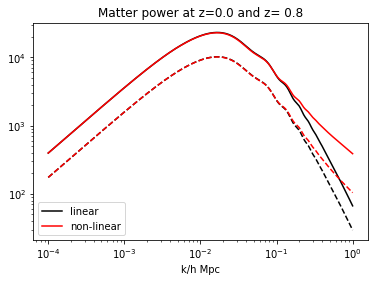

In [10]:
for i, (redshift, line) in enumerate(zip(z,['-','--'])):
    plt.loglog(kh, pk[i,:], color='k', ls = line)
    plt.loglog(kh_nonlin, pk_nonlin[i,:], color='r', ls = line)
plt.xlabel('k/h Mpc');
plt.legend(['linear','non-linear'], loc='lower left');
plt.title('Matter power at z=%s and z= %s'%tuple(z));

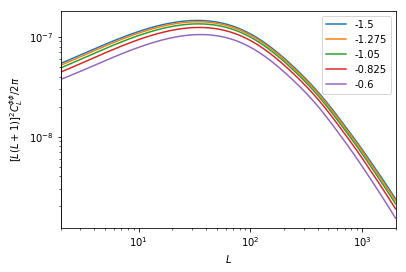

In [11]:
#Plot CMB lensing potential power for various values of w
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.InitPower.set_params(As=2e-9, ns=0.965)
pars.set_for_lmax(2000, lens_potential_accuracy=1)

ws = np.linspace(-1.5, -0.6, 5)
for w in ws:
    pars.set_dark_energy(w=w, wa=0, dark_energy_model='fluid') 
    results = camb.get_results(pars)
    cl = results.get_lens_potential_cls(lmax=2000)
    plt.loglog(np.arange(2001), cl[:,0])

plt.legend(ws)
plt.ylabel('$[L(L+1)]^2C_L^{\phi\phi}/2\pi$')
plt.xlabel('$L$')
plt.xlim([2,2000]);


You can view the parameters (as used by fortran CAMB) by just printing the parameter object.
See the [docs](https://camb.readthedocs.io/en/devel/model.html) for parameter and structure descriptions

In [12]:
print(pars)

WantCls = True
WantTransfer = False
WantScalars = True
WantTensors = False
WantVectors = False
WantDerivedParameters = True
Want_cl_2D_array = True
Want_CMB = True
Want_CMB_lensing = True
DoLensing = True
NonLinear = NonLinear_lens
Transfer: <TransferParams>
  high_precision = False
  accurate_massive_neutrinos = False
  kmax = 0.9
  k_per_logint = 0
  PK_num_redshifts = 1
  PK_redshifts = [0.0]
want_zstar = False
want_zdrag = False
min_l = 2
max_l = 2150
max_l_tensor = 600
max_eta_k = 18000.0
max_eta_k_tensor = 1200.0
ombh2 = 0.022
omch2 = 0.122
omk = 0.0
omnuh2 = 0.0006451383989381787
H0 = 67.5
TCMB = 2.7255
YHe = 0.2452238297943335
num_nu_massless = 2.030666666666667
num_nu_massive = 1
nu_mass_eigenstates = 1
share_delta_neff = False
nu_mass_degeneracies = [1.0153333333333332]
nu_mass_fractions = [1.0]
nu_mass_numbers = [1]
InitPower: <InitialPowerLaw>
  tensor_parameterization = tensor_param_rpivot
  ns = 0.965
  nrun = 0.0
  nrunrun = 0.0
  nt = -0.0
  ntrun = -0.0
  r = 0.0
  piv

w, wa model parameters:
 w = -1.2
wa = 0.2
cs2 = 1.0
use_tabulated_w = False

Table-interpolated parameters (w and wa are set to estimated values at 0):
w = -1.2
wa = 0.1993346429183863
cs2 = 1.0
use_tabulated_w = True



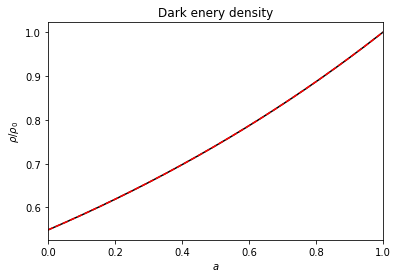

In [13]:
#The dark energy model can be changed as in the previous example, or by assigning to pars.DarkEnergy.
#e.g. use the PPF model
from camb.dark_energy import DarkEnergyPPF, DarkEnergyFluid
pars.DarkEnergy = DarkEnergyPPF(w=-1.2, wa=0.2)
print('w, wa model parameters:\n', pars.DarkEnergy)
results = camb.get_background(pars)

#or can also use a w(a) numerical function 
#(note this will slow things down; make your own dark energy class in fortran for best performance)
a = np.logspace(-5, 0, 1000)
w = -1.2 + 0.2 * (1 - a)
pars.DarkEnergy= DarkEnergyPPF()
pars.DarkEnergy.set_w_a_table(a, w)
print('Table-interpolated parameters (w and wa are set to estimated values at 0):')
print(pars.DarkEnergy)
results2 = camb.get_background(pars)

rho, _ = results.get_dark_energy_rho_w(a)
rho2, _ = results2.get_dark_energy_rho_w(a)
plt.plot(a, rho, color='k')
plt.plot(a, rho2, color='r', ls='--')
plt.ylabel(r'$\rho/\rho_0$')
plt.xlabel('$a$')
plt.xlim(0,1)
plt.title('Dark enery density');


In [14]:
#Get various background functions and derived parameters
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
results = camb.get_background(pars)
print('Derived parameter dictionary: %s'%results.get_derived_params())

Derived parameter dictionary: {'age': 13.74073861213516, 'zstar': 1090.56517181293, 'rstar': 144.20182553681536, 'thetastar': 1.0445813115420852, 'DAstar': 13.804748748944625, 'zdrag': 1059.2183861247001, 'rdrag': 146.98007569672905, 'kd': 0.14069479353706657, 'thetad': 0.1617496462193965, 'zeq': 3441.168556293452, 'keq': 0.010502751787534391, 'thetaeq': 0.8080626152962853, 'thetarseq': 0.44701539159866893}


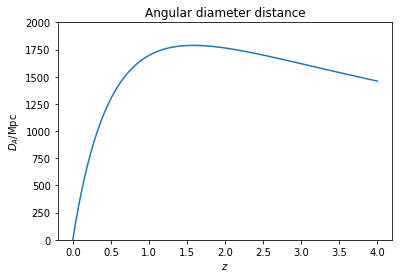

In [15]:
z = np.linspace(0,4,100)
DA = results.angular_diameter_distance(z)
plt.plot(z, DA)
plt.xlabel('$z$')
plt.ylabel(r'$D_A /\rm{Mpc}$')
plt.title('Angular diameter distance')
plt.ylim([0,2000]);

In [16]:
print('CosmoMC theta_MC parameter: %s'%results.cosmomc_theta())

CosmoMC theta_MC parameter: 0.010443416684015763


In [17]:
#You can also directly access some lower level quantities, for example the CMB transfer functions:
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
data = camb.get_transfer_functions(pars)
transfer = data.get_cmb_transfer_data()
print('Number of sources (T, E, phi..): %s; number of ell: %s; number of k: %s '%tuple(transfer.delta_p_l_k.shape))

Number of sources (T, E, phi..): 3; number of ell: 85; number of k: 2737 


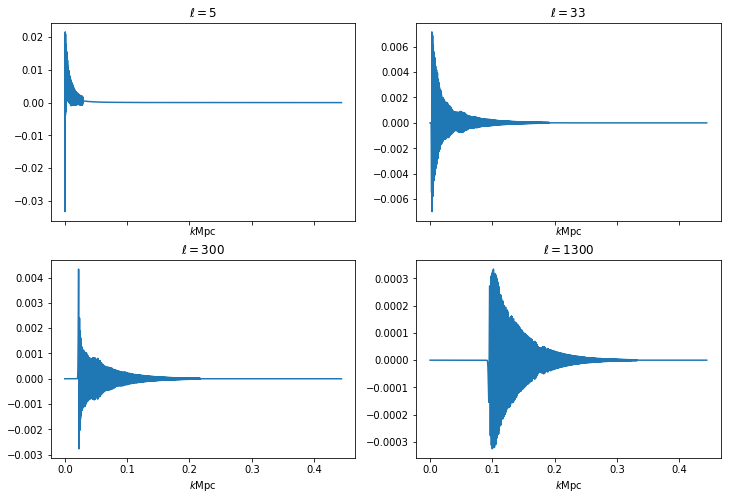

In [18]:
#Plot the transfer functions as a function of k for various ell
fig, axs = plt.subplots(2,2, figsize=(12,8), sharex = True)
for ix, ax in zip([3, 20, 40, 60],axs.reshape(-1)):
    ax.plot(transfer.q,transfer.delta_p_l_k[0,ix,:])
    ax.set_title(r'$\ell = %s$'%transfer.l[ix])
    if ix>1: ax.set_xlabel(r'$k \rm{Mpc}$')

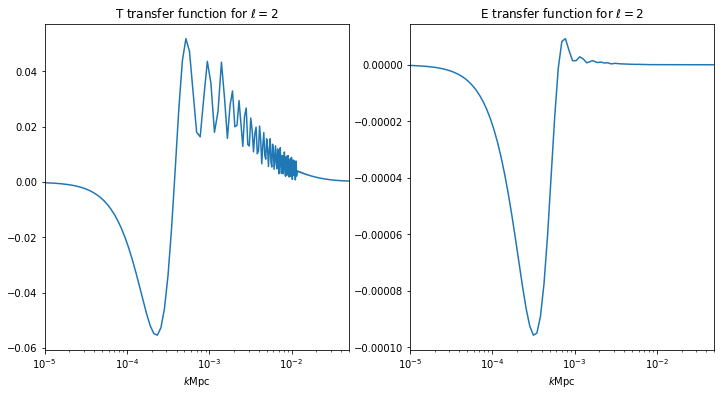

In [19]:
#Note that internal samplings can be quite sparsely sampled, e.g. look at l=2 transfer function
def plot_cmb_transfer_l(trans, ix):
    _, axs = plt.subplots(1,2, figsize=(12,6))
    for source_ix, (name, ax) in enumerate(zip(['T', 'E'], axs)):
        ax.semilogx(trans.q,trans.delta_p_l_k[source_ix,ix,:])
        ax.set_xlim([1e-5, 0.05])
        ax.set_xlabel(r'$k \rm{Mpc}$')
        ax.set_title(r'%s transfer function for $\ell = %s$'%(name, trans.l[ix]))
plot_cmb_transfer_l(transfer,0)

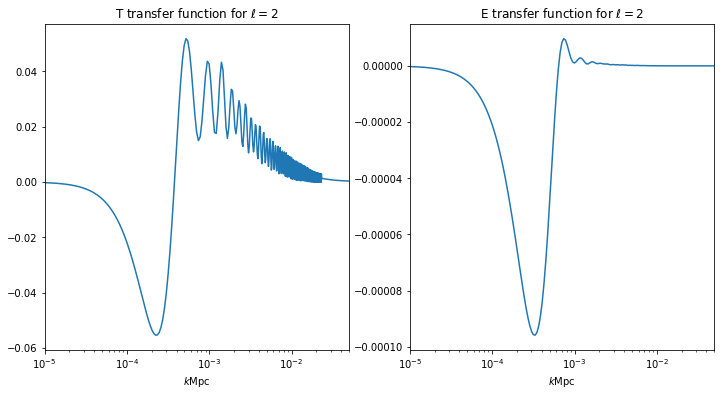

In [20]:
#So if you want to make nice plots, either interpolate or do things at higher than default accuracy
pars.set_accuracy(AccuracyBoost=2) #higher accuracy, so higher sampling density
data = camb.get_transfer_functions(pars)
plot_cmb_transfer_l(data.get_cmb_transfer_data(),0)
pars.set_accuracy(AccuracyBoost=1); #re-set default

Calculated L: [  2   3   4   5   6   7   8   9  10  11  13  15  17  19  21  23  25  27
  29  31  33  35  37  40  45  50  55  60  65  70  75  80  85  90 110 130
 150 175 200 250 300 350 400 450 500 550 600]


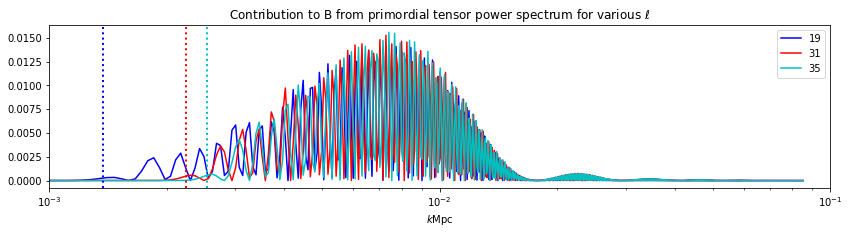

In [21]:
#Similarly for tensor transfer function 
#e.g. see where various C_L^BB come from in k by plotting normalized transfer**2 (C_l is ~ integral over log k P(k) T(k)^2)
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.WantScalars = False
pars.WantTensors = True
pars.set_accuracy(AccuracyBoost=2)
data = camb.get_transfer_functions(pars)
transfer = data.get_cmb_transfer_data('tensor')
print(r'Calculated L: %s'%transfer.l)
plt.figure(figsize=(14,3))
ixs=[13,19,21]
ls = [transfer.l[i] for i in ixs]
cols=['b','r','c']
for ix,col in zip(ixs, cols):
    k_weight = transfer.delta_p_l_k[2,ix,:]**2
    k_weight /= np.sum(k_weight)
    plt.semilogx(transfer.q,k_weight, color=col)
plt.xlim([1e-3, 0.1])
plt.legend(ls)
plt.xlabel(r'$k \rm{Mpc}$')
plt.title(r'Contribution to B from primordial tensor power spectrum for various $\ell$')
#compare with k_* = l/chi*, note DAstar is in GPc, so multiply by 1000 to get standard Mpc units used for k
derived = data.get_derived_params()
for l,col in zip(ls,cols):
    plt.axvline(l/(1000*derived['DAstar']), color=col, ls=':', lw=2)

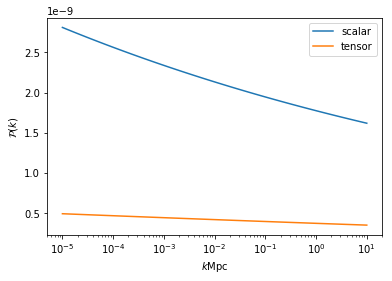

In [22]:
#if you want to combine the transfer functions with the primordial power spectra, you can get the latter via
k=10**np.linspace(-5, 1, 50)
pars.InitPower.set_params(ns=0.96, r=0.2) #this functions imposes inflation consistency relation by default
scalar_pk= pars.scalar_power(k)
tensor_pk= pars.tensor_power(k)
plt.semilogx(k,scalar_pk);
plt.semilogx(k,tensor_pk);
plt.xlabel(r'$k \rm{Mpc}$')
plt.ylabel(r'${\cal P}(k)$')
plt.legend(['scalar', 'tensor']);

In [23]:
#set_params is a shortcut routine for setting many things at once
pars = camb.set_params(H0=67.5, ombh2=0.022, omch2=0.122, As=2e-9, ns=0.95)
data= camb.get_background(pars)

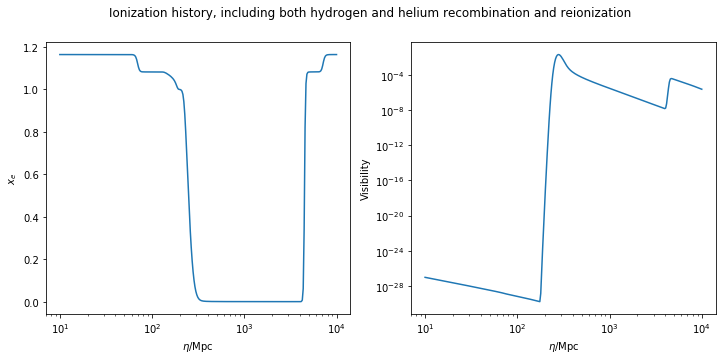

In [24]:
#There are functions get plot evolution of variables, e.g. for the background as a function of conformal time:
eta = 10**(np.linspace(1, 4,300))
back_ev = data.get_background_time_evolution(eta, ['x_e', 'visibility'])
fig, axs= plt.subplots(1,2, figsize=(12,5))
axs[0].semilogx(eta, back_ev['x_e'])
axs[1].loglog(eta, back_ev['visibility'])
axs[0].set_xlabel(r'$\eta/\rm{Mpc}$')
axs[0].set_ylabel('$x_e$')
axs[1].set_xlabel(r'$\eta/\rm{Mpc}$')
axs[1].set_ylabel('Visibility');
fig.suptitle('Ionization history, including both hydrogen and helium recombination and reionization');

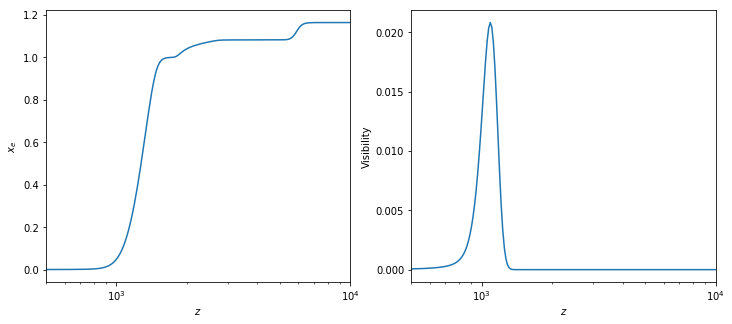

In [25]:
#or as a function of redshift
z = 10**np.linspace(2, 4, 300)
back_ev = data.get_background_redshift_evolution(z, ['x_e', 'visibility'], format='array')
fig, axs= plt.subplots(1,2, figsize=(12,5))
for i, (ax, label), in enumerate(zip(axs, ['$x_e$','Visibility'])):
    ax.semilogx(z, back_ev[:,i])
    ax.set_xlabel('$z$')
    ax.set_ylabel(label)
    ax.set_xlim([500,1e4])

In [26]:
#and perturbation transfer functions, e.g. for k=0.1. Note that quantities are synchronous gauge unless otherwise specified
print('Available variables are %s'%camb.model.evolve_names)

Available variables are ['k/h', 'delta_cdm', 'delta_baryon', 'delta_photon', 'delta_neutrino', 'delta_nu', 'delta_tot', 'delta_nonu', 'delta_tot_de', 'Weyl', 'v_newtonian_cdm', 'v_newtonian_baryon', 'v_baryon_cdm', 'a', 'etak', 'H', 'growth', 'v_photon', 'pi_photon', 'E_2', 'v_neutrino', 'T_source', 'E_source', 'lens_potential_source']


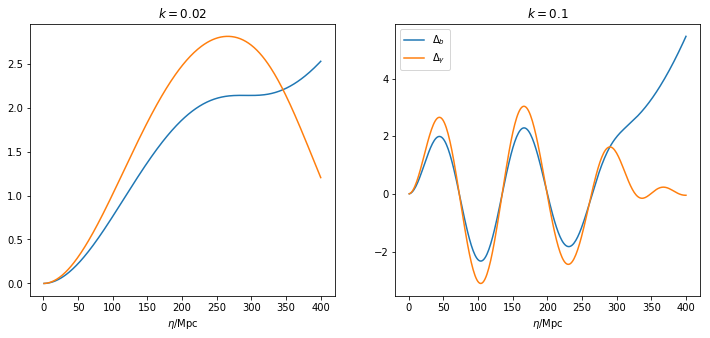

In [27]:
eta = np.linspace(1, 400, 300)
ks = [0.02,0.1]
ev = data.get_time_evolution(ks, eta, ['delta_baryon','delta_photon'])
_, axs= plt.subplots(1,2, figsize=(12,5))
for i, ax in enumerate(axs):
    ax.plot(eta,ev[i,:, 0])
    ax.plot(eta,ev[i,:, 1])
    ax.set_title('$k= %s$'%ks[i])
    ax.set_xlabel(r'$\eta/\rm{Mpc}$');
plt.legend([r'$\Delta_b$', r'$\Delta_\gamma$'], loc = 'upper left');


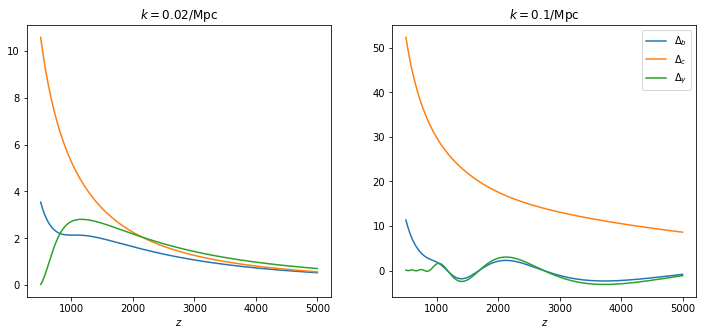

In [28]:
#or as a function of redshift
z = np.linspace(500,5000,300)
ks = [0.02,0.1]
ev = data.get_redshift_evolution(ks, z, ['delta_baryon','delta_cdm', 'delta_photon'])
_, axs= plt.subplots(1,2, figsize=(12,5))
for i, ax in enumerate(axs):
    ax.plot(z,ev[i,:, 0])
    ax.plot(z,ev[i,:, 1])
    ax.plot(z,ev[i,:, 2])
    ax.set_title(r'$k= %s/\rm{Mpc}$'%ks[i])
    ax.set_xlabel('$z$');
plt.legend([r'$\Delta_b$', r'$\Delta_c$', r'$\Delta_\gamma$'], loc = 'upper right');

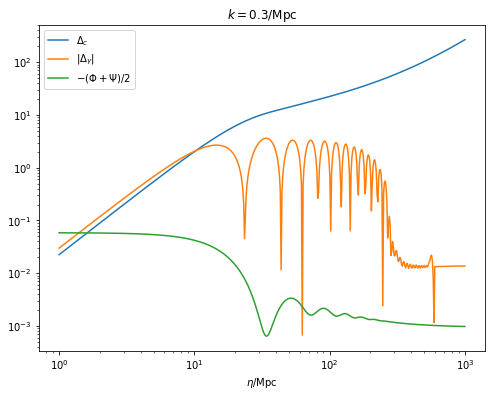

In [29]:
#Here you can see oscillation of delta_photon, subsequent decay of the potential and change to Mezsaroz growth in delta_cdm
eta = 10**(np.linspace(0, 3, 500))
def plot_ev(ev, k):
    plt.figure(figsize=(8,6))
    plt.loglog(eta,ev[:,0])
    plt.loglog(eta,np.abs(ev[:,1]))
    plt.loglog(eta,-ev[:,2])
    plt.title(r'$k= %s/\rm{Mpc}$'%k)
    plt.xlabel(r'$\eta/\rm{Mpc}$');
    plt.legend([r'$\Delta_c$', r'$|\Delta_\gamma|$', r'$-(\Phi+\Psi)/2$'], loc = 'upper left');

k=0.3
plot_ev(data.get_time_evolution(k, eta, ['delta_cdm','delta_photon', 'Weyl']),k)


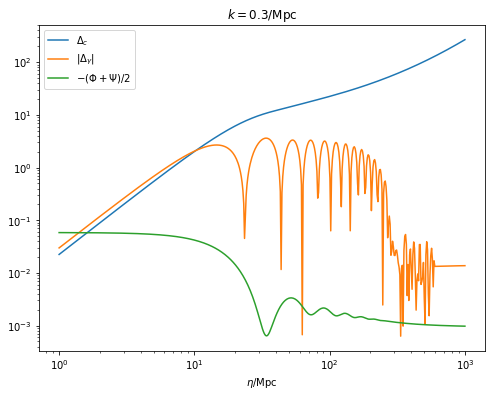

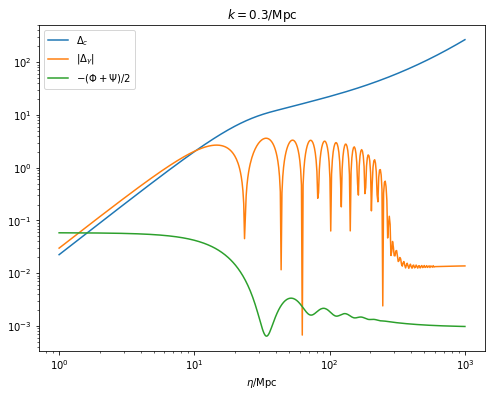

In [30]:
#Note that time evolution can be visually quite sensitive to accuracy. By default it is boosted, but you can change this. e.g.
plot_ev(data.get_time_evolution(k, eta, ['delta_cdm','delta_photon', 'Weyl'],lAccuracyBoost=1),k)
plot_ev(data.get_time_evolution(k, eta, ['delta_cdm','delta_photon', 'Weyl'],lAccuracyBoost=10),k)

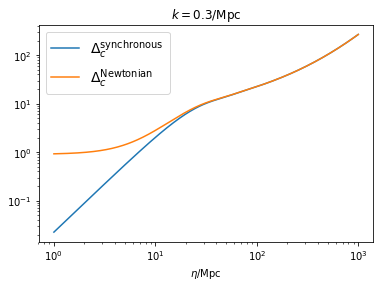

In [31]:
#It's also possible to plot quantities in other gauges, or arbitrary symbolic expressions,
#using camb.symbolic.
#For example, this plots the Newtonian gauge density compared to the synchronous gauge one
import camb.symbolic as cs
Delta_c_N = cs.make_frame_invariant(cs.Delta_c, 'Newtonian')
ev=data.get_time_evolution(k, eta, ['delta_cdm',Delta_c_N])
plt.figure(figsize=(6,4))
plt.loglog(eta,ev[:,0])
plt.loglog(eta,ev[:,1])
plt.title(r'$k= %s/\rm{Mpc}$'%k)
plt.xlabel(r'$\eta/\rm{Mpc}$');
plt.legend([r'$\Delta_c^{\rm synchronous}$', r'$\Delta_c^{\rm Newtonian}$'], fontsize=14);

For further details of camb.symbolic and examples of what can be done see the [CAMB symbolic ScalEqs notebook](http://camb.readthedocs.org/en/latest/ScalEqs.html) (run now in [Binder](https://mybinder.org/v2/gh/cmbant/camb/master?filepath=pycamb%2Fdocs%2FScalEqs.ipynb)). This also serves as documentation for the scalar equations implemented in CAMB.

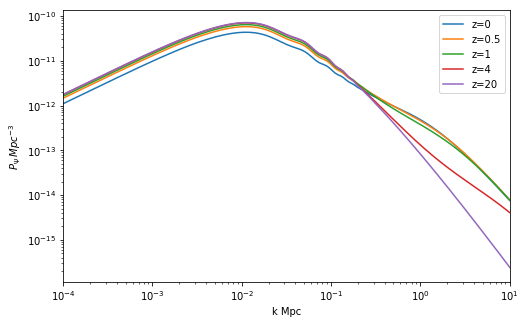

In [32]:
#For calculating large-scale structure and lensing results yourself, get a power spectrum
#interpolation object. In this example we calculate the CMB lensing potential power
#spectrum using the Limber approximation, using PK=camb.get_matter_power_interpolator() function.
#calling PK(z, k) will then get power spectrum at any k and redshift z in range.

nz = 100 #number of steps to use for the radial/redshift integration
kmax=10  #kmax to use
#First set up parameters as usual
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.InitPower.set_params(ns=0.965)

#For Limber result, want integration over \chi (comoving radial distance), from 0 to chi_*.
#so get background results to find chistar, set up arrage in chi, and calculate corresponding redshifts
results= camb.get_background(pars)
chistar = results.conformal_time(0)- results.tau_maxvis
chis = np.linspace(0,chistar,nz)
zs=results.redshift_at_comoving_radial_distance(chis)
#Calculate array of delta_chi, and drop first and last points where things go singular
dchis = (chis[2:]-chis[:-2])/2
chis = chis[1:-1]
zs = zs[1:-1]

#Get the matter power spectrum interpolation object (based on RectBivariateSpline). 
#Here for lensing we want the power spectrum of the Weyl potential.
PK = camb.get_matter_power_interpolator(pars, nonlinear=True, 
    hubble_units=False, k_hunit=False, kmax=kmax,
    var1=model.Transfer_Weyl,var2=model.Transfer_Weyl, zmax=zs[-1])

#Have a look at interpolated power spectrum results for a range of redshifts
#Expect linear potentials to decay a bit when Lambda becomes important, and change from non-linear growth
plt.figure(figsize=(8,5))
k=np.exp(np.log(10)*np.linspace(-4,2,200))
zplot = [0, 0.5, 1, 4 ,20]
for z in zplot:
    plt.loglog(k, PK.P(z,k))
plt.xlim([1e-4,kmax])
plt.xlabel('k Mpc')
plt.ylabel('$P_\Psi\, Mpc^{-3}$')
plt.legend(['z=%s'%z for z in zplot]);


Now do integral to get convergence power spectrum, using Limber approximation ($k\approx (l+0.5)/\chi$)
$$
C_l^\kappa \approx  [l(l+1)]^2\int_0^{\chi_*} d\chi \left( \frac{\chi_*-\chi}{\chi^2\chi_*}\right)^2 P_\Psi\left(\frac{l+0.5}{\chi}, z(\chi)\right)
$$
where $P_\Psi $ is obtained from the interpolator.

In [33]:
#Get lensing window function (flat universe)
win = ((chistar-chis)/(chis**2*chistar))**2
#Do integral over chi
ls = np.arange(2,2500+1, dtype=np.float64)
cl_kappa=np.zeros(ls.shape)
w = np.ones(chis.shape) #this is just used to set to zero k values out of range of interpolation
for i, l in enumerate(ls):
    k=(l+0.5)/chis
    w[:]=1
    w[k<1e-4]=0
    w[k>=kmax]=0
    cl_kappa[i] = np.dot(dchis, w*PK.P(zs, k, grid=False)*win/k**4)
cl_kappa*= (ls*(ls+1))**2

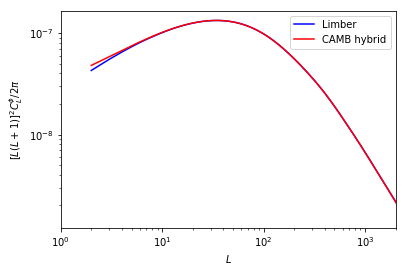

In [34]:
#Compare with CAMB's calculation:
#note that to get CAMB's internal calculation accurate at the 1% level at L~2000, 
#need lens_potential_accuracy=2. Increase to 4 for accurate match to the Limber calculation here
pars.set_for_lmax(2500,lens_potential_accuracy=2)
results = camb.get_results(pars)
cl_camb=results.get_lens_potential_cls(2500) 
#cl_camb[:,0] is phi x phi power spectrum (other columns are phi x T and phi x E)

#Make plot. Expect difference at very low-L from inaccuracy in Limber approximation, and
#very high L from differences in kmax (lens_potential_accuracy is only 2, though good by eye here)
cl_limber= 4*cl_kappa/2/np.pi #convert kappa power to [l(l+1)]^2C_phi/2pi (what cl_camb is)
plt.loglog(ls,cl_limber, color='b')
plt.loglog(np.arange(2,cl_camb[:,0].size),cl_camb[2:,0], color='r')
plt.xlim([1,2000])
plt.legend(['Limber','CAMB hybrid'])
plt.ylabel('$[L(L+1)]^2C_L^{\phi}/2\pi$')
plt.xlabel('$L$');


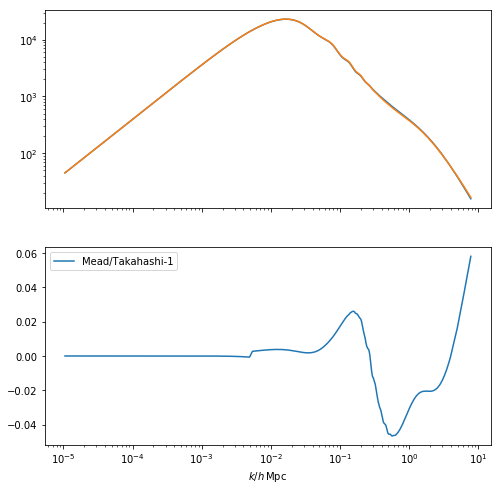

In [35]:
#The non-linear model can be changed like this:
pars.set_matter_power(redshifts=[0.], kmax=2.0)
pars.NonLinearModel.set_params(halofit_version='takahashi')
kh_nonlin, _, pk_takahashi = results.get_nonlinear_matter_power_spectrum(params=pars)
pars.NonLinearModel.set_params(halofit_version='mead')
kh_nonlin, _, pk_mead = results.get_nonlinear_matter_power_spectrum(params=pars)

fig, axs=plt.subplots(2,1, sharex=True, figsize=(8,8))
axs[0].loglog(kh_nonlin, pk_takahashi[0])
axs[0].loglog(kh_nonlin, pk_mead[0])
axs[1].semilogx(kh_nonlin, pk_mead[0]/pk_takahashi[0]-1)
axs[1].set_xlabel(r'$k/h\, \rm{Mpc}$')    
axs[1].legend(['Mead/Takahashi-1'], loc='upper left');

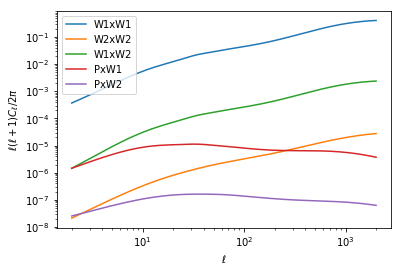

In [36]:
#Get angular power spectrum for galaxy number counts and lensing
from camb.sources import GaussianSourceWindow, SplinedSourceWindow

pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.InitPower.set_params(As=2e-9, ns=0.965)
pars.set_for_lmax(lmax, lens_potential_accuracy=1)
#set Want_CMB to true if you also want CMB spectra or correlations
pars.Want_CMB = False 
#NonLinear_both or NonLinear_lens will use non-linear corrections
pars.NonLinear = model.NonLinear_both
#Set up W(z) window functions, later labelled W1, W2. Gaussian here.
pars.SourceWindows = [
    GaussianSourceWindow(redshift=0.17, source_type='counts', bias=1.2, sigma=0.04, dlog10Ndm=-0.2),
    GaussianSourceWindow(redshift=0.5, source_type='lensing', sigma=0.07)]

results = camb.get_results(pars)
cls = results.get_source_cls_dict()

#Note that P is CMB lensing, as a deflection angle power (i.e. PxP is [l(l+1)]^2C_l\phi\phi/2\pi)
#lensing window functions are for kappa (and counts for the fractional angular number density)
ls=  np.arange(2, lmax+1)
for spectrum in ['W1xW1','W2xW2','W1xW2',"PxW1", "PxW2"]:
    plt.loglog(ls, cls[spectrum][2:lmax+1], label=spectrum)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')
plt.legend();


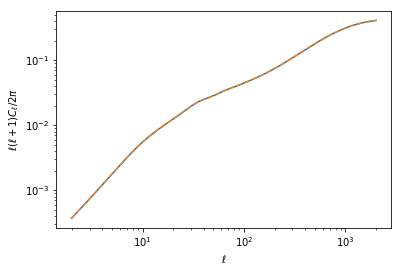

In [37]:
#You can also use window functions from numerical table of W(z). It must be well enough sampled to interpolate nicely.
#e.g. reproduce Gaussian this way..
zs = np.arange(0, 0.5, 0.02)
W = np.exp(-(zs - 0.17) ** 2 / 2 / 0.04 ** 2) / np.sqrt(2 * np.pi) / 0.04
pars.SourceWindows = [SplinedSourceWindow(bias=1.2, dlog10Ndm=-0.2, z=zs, W=W)]
results = camb.get_results(pars)
cls2 = results.get_cmb_unlensed_scalar_array_dict()
plt.loglog(ls, cls["W1xW1"][2:lmax+1], label=spectrum)
plt.loglog(ls, cls2["W1xW1"][2:lmax+1],ls='--')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$');


In [38]:
#Sources can include various terms using these options (line_xx refers to 21cm)
print(pars.SourceTerms)

limber_windows = True
limber_phi_lmin = 100
counts_density = True
counts_redshift = True
counts_lensing = False
counts_velocity = True
counts_radial = False
counts_timedelay = True
counts_ISW = True
counts_potential = True
counts_evolve = False
line_phot_dipole = False
line_phot_quadrupole = False
line_basic = True
line_distortions = True
line_extra = False
line_reionization = False
use_21cm_mK = True



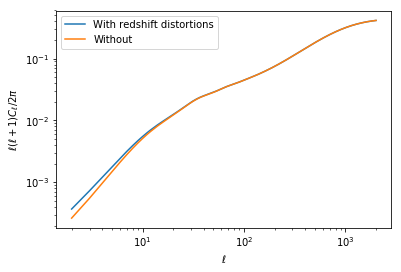

In [39]:
#Results above include redshift distortions but not magnification bias (counts_lensing). 
#Try turning off redshift distortions:
pars.SourceTerms.counts_redshift = False
results = camb.get_results(pars)
cls3 = results.get_source_cls_dict()

plt.loglog(ls, cls["W1xW1"][2:lmax+1])
plt.loglog(ls, cls3["W1xW1"][2:lmax+1])
plt.legend(['With redshift distortions', 'Without'])
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$');


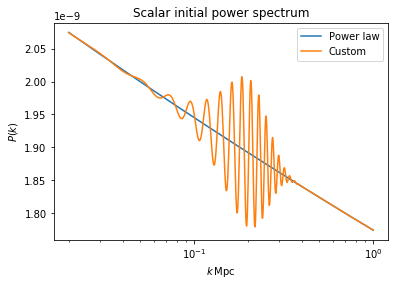

In [40]:
#Let's look at some non-standard primordial power spectrum, e.g. with wavepacket oscillation

#Define our custom  power spectrum function (here power law with one wavepacket)
def PK(k, As, ns, amp, freq, wid, centre, phase):
    return As*(k/0.05)**(ns-1)*(1+ np.sin(phase+k*freq)*amp*np.exp(-(k-centre)**2/wid**2))

#Check how this looks compared to power law
ks = np.linspace(0.02,1,1000)
pk1 = 2e-9*(ks/0.05)**(0.96-1)
pk2 = PK(ks,2e-9, 0.96,0.0599, 280, 0.08, 0.2,0)
plt.semilogx(ks,pk1)
plt.semilogx(ks,pk2)
plt.ylabel('$P(k)$')
plt.xlabel(r'$k\, {\rm Mpc}$')
plt.legend(['Power law','Custom'])
plt.title('Scalar initial power spectrum');

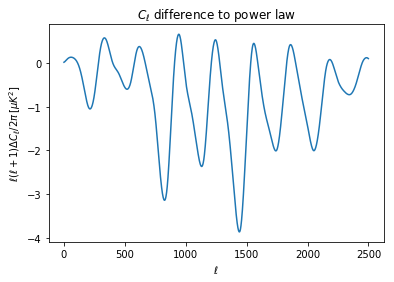

In [41]:
#Now compute C_l and compare
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, tau=0.06)
lmax=2500
pars.set_for_lmax(lmax,lens_potential_accuracy=1)

#For comparison, standard power law
pars.InitPower.set_params(As=2e-9, ns=0.96)
results = camb.get_results(pars)
cl_unlensed=results.get_unlensed_scalar_cls(CMB_unit ='muK')
cl=results.get_lensed_scalar_cls(CMB_unit ='muK')

#Not get custom spectrum
pars.set_initial_power_function(PK, args=(2e-9, 0.96,0.0599, 280, 0.08, 0.2,0))

results2 = camb.get_results(pars)
cl2=results2.get_lensed_scalar_cls(CMB_unit ='muK')

ls = np.arange(2,lmax)
plt.plot(ls,(cl2[2:lmax,0]-cl[2:lmax,0]))
plt.xlabel(r'$\ell$');
plt.ylabel(r'$\ell(\ell+1)\Delta C_\ell/2\pi\, [\mu K^2]$')
plt.title(r'$C_\ell$ difference to power law');


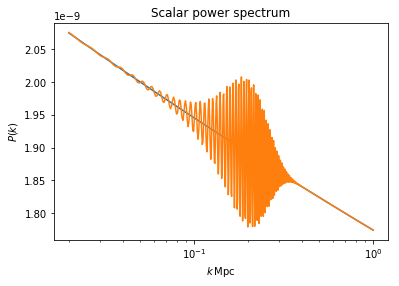

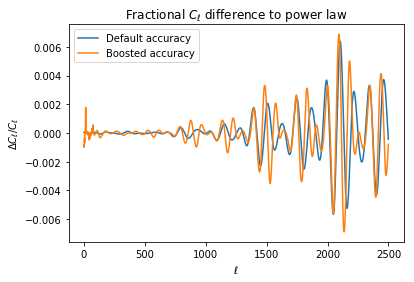

In [42]:
#Note that if you have sharp features or fine oscillations, you may need 
#increase accuracy to sample them well. e.g. let's try increasing the frequency

#Default accuracy
pars.Accuracy.lSampleBoost = 1
pars.Accuracy.IntkAccuracyBoost =1
pars.Accuracy.SourcekAccuracyBoost =1

freq = 1000
ks = np.linspace(0.02,1,1000)
pk1 = 2e-9*(ks/0.05)**(0.96-1)
pk2 = PK(ks,2e-9, 0.96,0.0599,freq, 0.08, 0.2,0)
plt.semilogx(ks,pk1)
plt.semilogx(ks,pk2)
plt.ylabel('$P(k)$')
plt.xlabel(r'$k\, {\rm Mpc}$');
plt.title('Scalar power spectrum')
plt.figure()

pars.set_initial_power_function(PK, args=(2e-9, 0.96,0.0599, freq, 0.08, 0.2,0))

results2 = camb.get_results(pars)
cl_unlensed2=results2.get_unlensed_scalar_cls(CMB_unit ='muK')

#need to increase default sampling in ell to see features smaller than peaks reliably
pars.Accuracy.lSampleBoost = 2
#may also need to sample k more densely when computing C_l from P(k)
pars.Accuracy.IntkAccuracyBoost = 2 

results3 = camb.get_results(pars)
cl_unlensed3=results3.get_unlensed_scalar_cls(CMB_unit ='muK')
cl3=results3.get_lensed_scalar_cls(CMB_unit ='muK')

ls = np.arange(2,lmax)
plt.plot(ls,(cl_unlensed2[2:lmax,0]/cl_unlensed[2:lmax,0]-1))
plt.plot(ls,(cl_unlensed3[2:lmax,0]/cl_unlensed[2:lmax,0]-1))

plt.xlabel(r'$\ell$')
plt.ylabel(r'$\Delta C_\ell/C_\ell$')
plt.title(r'Fractional $C_\ell$ difference to power law')
plt.legend(['Default accuracy','Boosted accuracy']);


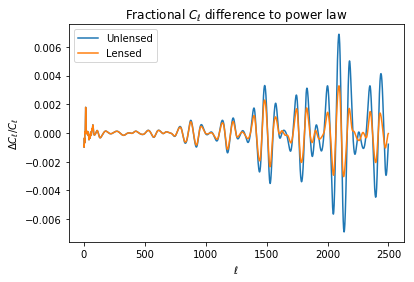

In [43]:
#Note that lensing washes out small features on small scales
plt.plot(ls,(cl_unlensed3[2:lmax,0]/cl_unlensed[2:lmax,0]-1))
plt.plot(ls,(cl3[2:lmax,0]/cl[2:lmax,0]-1))
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\Delta C_\ell/C_\ell$')
plt.legend(['Unlensed','Lensed'])
plt.title(r'Fractional $C_\ell$ difference to power law');

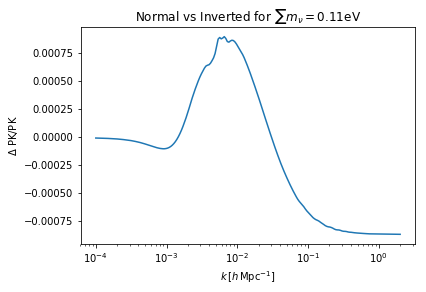

In [44]:
#Now look at the (small!) effect of neutrino mass splittings on the matter power spectrum (in linear theory)
#The "neutrino_hierarchy" parameter uses a two eigenstate approximation to the full hierarchy (which is very accurate for cosmology)
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.11, neutrino_hierarchy='normal')
pars.InitPower.set_params(ns=0.965)
pars.set_matter_power(redshifts=[0.], kmax=2.0)
results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=2, npoints = 200)

pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.11, neutrino_hierarchy='inverted')
results = camb.get_results(pars)
kh2, z2, pk2 = results.get_matter_power_spectrum(minkh=1e-4, maxkh=2, npoints = 200)

plt.semilogx(kh, pk2[0,:]/pk[0,:]-1)
plt.ylabel('$\Delta$ PK/PK')
plt.xlabel(r'$k\, [h \,\rm{Mpc}^{-1}]$')
plt.title(r'Normal vs Inverted for $\sum m_\nu=0.11 \rm{eV}$');